In [28]:
import pandas as pd
import os
import requests
import json
import numpy as np
from scipy.stats import gaussian_kde

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [30]:
from preprocessing_utils import preprocess_NVD_data

In [31]:
data_path = 'data'
if not os.path.exists(data_path):
    os.makedirs(data_path)

# EPSS data

Download the EPSS data from https://www.first.org/epss/data_stats into `data` folder

In [32]:
epss_current = pd.read_csv(os.path.join(
    data_path, 'epss_scores-2025-10-05.csv.gz'), compression='gzip', header=1)
epss_current  # a Python statement with a variable name at the end of a cell will display its contents below

,cve,epss,percentile
0,CVE-1999-0001,0.01076,0.77053
1,CVE-1999-0002,0.15339,0.94381
2,CVE-1999-0003,0.90362,0.99577
3,CVE-1999-0004,0.03215,0.86538
4,CVE-1999-0005,0.25334,0.96002
...,...,...,...
296849,CVE-2025-9994,0.00063,0.20046
296850,CVE-2025-9996,0.00179,0.39898
296851,CVE-2025-9997,0.00182,0.40254
296852,CVE-2025-9998,0.00023,0.04721


In [33]:
epss_old = pd.read_csv(os.path.join(
    data_path, 'epss_scores-2025-09-28.csv.gz'), compression='gzip', header=1)

# NVD data

In [34]:
base_url = "https://services.nvd.nist.gov/rest/json/cves/2.0"
date_start_NVD = '2025-09-01T00:00:00.000Z'  # Do NOT change these dates
date_end_NVD = '2025-10-01T00:00:00.000Z'  # Do NOT change these dates
start_index = 0
results_per_page = 1000
total_results = 1

all_cves = []

while start_index < total_results:
    params = {
        "pubStartDate": date_start_NVD,
        "pubEndDate": date_end_NVD,
        "resultsPerPage": results_per_page,
        "startIndex": start_index,
        "noRejected": ""
    }
    response = requests.get(base_url, params=params, timeout=6)
    if response.status_code != 200:
        print("Error:", response.status_code)
        break

    data = response.json()
    total_results = data.get("totalResults", 0)

    all_cves.extend(data.get("vulnerabilities", []))

    start_index += results_per_page
    print(start_index)

1000
2000
3000
4000
5000


In [35]:
# normalize and preprocess data
df = pd.json_normalize(all_cves, record_path=None, sep='.', max_level=None)
df = preprocess_NVD_data(df)

# remove vulnerabilities marked as "reject" or "reserved"
df = df[(df['cve.vulnStatus'] != 'Reserved')
        & (df['cve.vulnStatus'] != 'Reject')]

# merge NVD and EPSS data
df = df.merge(epss_current, left_on="cve.id",
              right_on="cve", how="left")
df = df.merge(epss_old, left_on='cve.id', right_on='cve',
              how='left')

In [36]:
# save nvd data
with open(os.path.join(data_path, "nvd_cves.json"), "w", encoding="utf-8") as f:
    json.dump(all_cves, f, indent=2)

# save the final dataframe
df.to_csv(os.path.join(data_path, "vuln_2025_09.csv"))

# Exploratory Data Analysis

- display some examples (e.g., the first two CVE records)

In [37]:
print(df.columns)

Index(['cve.id', 'cve.sourceIdentifier', 'cve.published', 'cve.lastModified',
       'cve.vulnStatus', 'cve.references', 'cve.cisaExploitAdd',
       'cve.cisaActionDue', 'cve.cisaRequiredAction',
       'cve.cisaVulnerabilityName', 'description', 'vulnerable_cpes',
       'num_references', 'cwe_list', 'cvss_version', 'cvss_vectorString',
       'cvss_baseScore', 'cvss_baseSeverity', 'cvss_attackVector',
       'cvss_attackComplexity', 'cvss_privilegesRequired',
       'cvss_userInteraction', 'cvss_scope', 'cvss_confidentialityImpact',
       'cvss_integrityImpact', 'cvss_availabilityImpact', 'cve_x', 'epss_x',
       'percentile_x', 'cve_y', 'epss_y', 'percentile_y'],
      dtype='object')


- show a bar plot with the daily volume of published CVEs

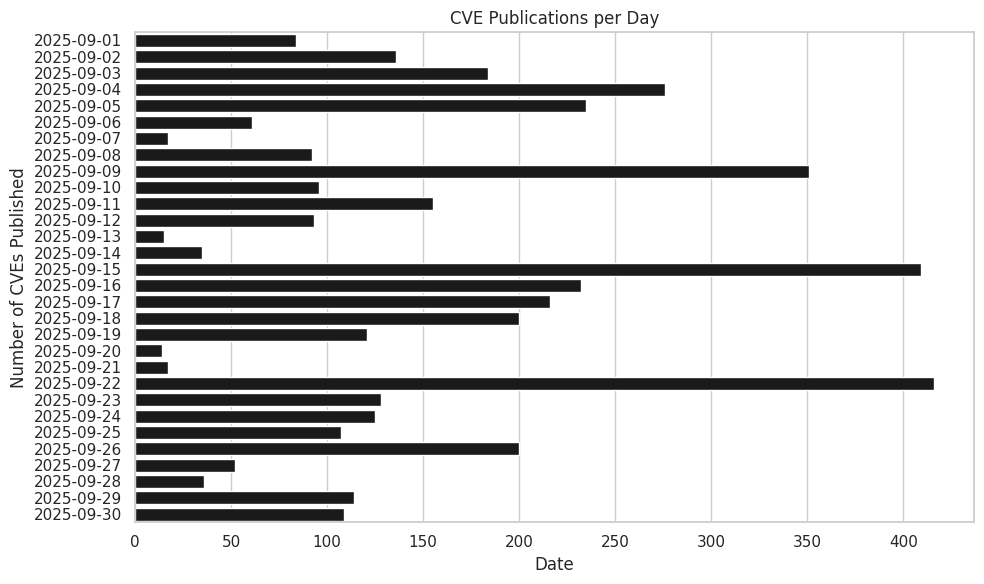

In [38]:
published_counts = df["cve.published"].dt.date.value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=published_counts.values, y=published_counts.index, color="k")
plt.xlabel("Date")
plt.ylabel("Number of CVEs Published")
plt.title("CVE Publications per Day")
plt.tight_layout()
plt.show()

In [39]:
df.head(2).T

,0,1
cve.id,CVE-2025-9751,CVE-2025-9752
cve.sourceIdentifier,cna@vuldb.com,cna@vuldb.com
cve.published,2025-09-01 00:15:34.580000,2025-09-01 01:15:46.817000
cve.lastModified,2025-09-08 14:06:05.217000,2025-09-04 18:47:25.440000
cve.vulnStatus,Analyzed,Analyzed
cve.references,[{'url': 'https://github.com/HAO-RAY/HCR-CVE/i...,[{'url': 'https://github.com/i-Corner/cve/issu...
cve.cisaExploitAdd,NaN,NaN
cve.cisaActionDue,NaN,NaN
cve.cisaRequiredAction,NaN,NaN
cve.cisaVulnerabilityName,NaN,NaN


- print the description of the last ten published vulnerabilities

In [40]:
for idx, x in enumerate(df.sort_values('cve.published', ascending=False)[:10].iterrows()):
    print('-'*100)
    print(x[1]['cve.id'], x[1]['cve.published'])
    print(x[1].description)

----------------------------------------------------------------------------------------------------
CVE-2025-61792 2025-09-30 23:15:29.700000
Quadient DS-700 iQ devices through 2025-09-30 might have a race condition during the quick clicking of (in order) the Question Mark button, the Help Button, the About button, and the Help Button, leading to a transition out of kiosk mode into local administrative access. NOTE: the reporter indicates that the "behavior was observed sporadically" during "limited time on the client site," making it not "possible to gain more information about the specific kiosk mode crashing issue," and the only conclusion was "there appears to be some form of race condition." Accordingly, there can be doubt that a reproducible cybersecurity vulnerability was identified; sporadic software crashes can also be caused by a hardware fault on a single device (for example, transient RAM errors). The reporter also describes a variety of other issues, including initial acc

### <font color='blue'><b><i>TODO</i></b>: produce plots or tables to address the folowing points</font>
- what is the percentage of CVEs which received a CVSS score?
- report descriptive statistics of CVSS the CVSS base score and/or show its distribution
- report descriptive statistics of EPSS and/or show its distribution
- produce a scatter plot showing CVSS vs EPSS
- <b>be creative</b>!
    - How many vulnerabilities are published on CISA KEV? 
    - What are the the 20 most frequent vendors? (vendor name can be extracted from the `vulnerable_cpes` field).
    - What are the 20 most frequent CWEs?
    - Anaything else you see fit!

<font color='blue'>Use text cells to discuss the outcome after each point</font>

## CVEs with EPSS

In [41]:
print(
    f'Percentage of CVEs with a CVSS base score: {df["cvss_baseScore"].notna().sum() / len(df) * 100:.2f} %')

Percentage of CVEs with a CVSS base score: 76.77 %


About three quarters of CVEs have a CVSS base score assigned, meaning that enough information about such CVEs was obtained in order to produce an initial analysis.

## CVSS statistics

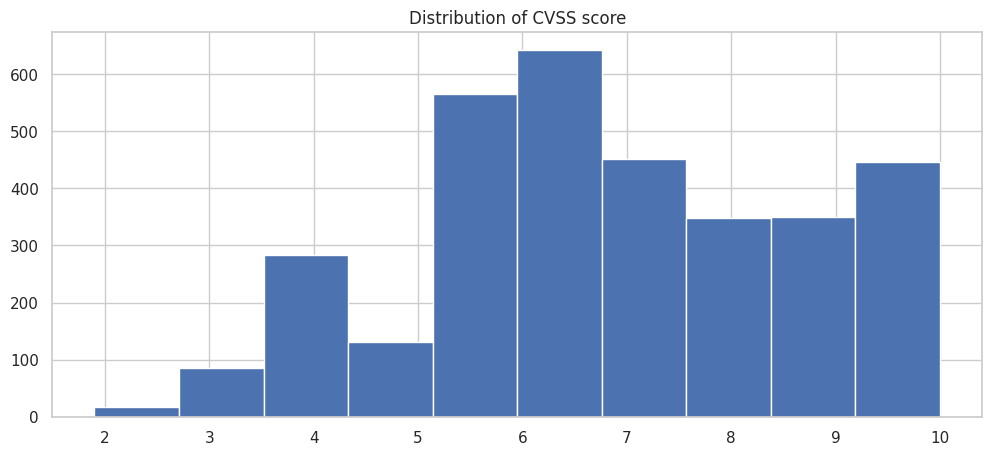

In [42]:
cvsss = df[df["cvss_baseScore"].notna()]
plt.figure(figsize=(12, 5))
plt.title("Distribution of CVSS score")
plt.hist(cvsss["cvss_baseScore"])
plt.show()

Of all the new CVEs that received a CVSS, we can see that these concentrate in the 'higher-risk' zone, spanning from 5 to 10

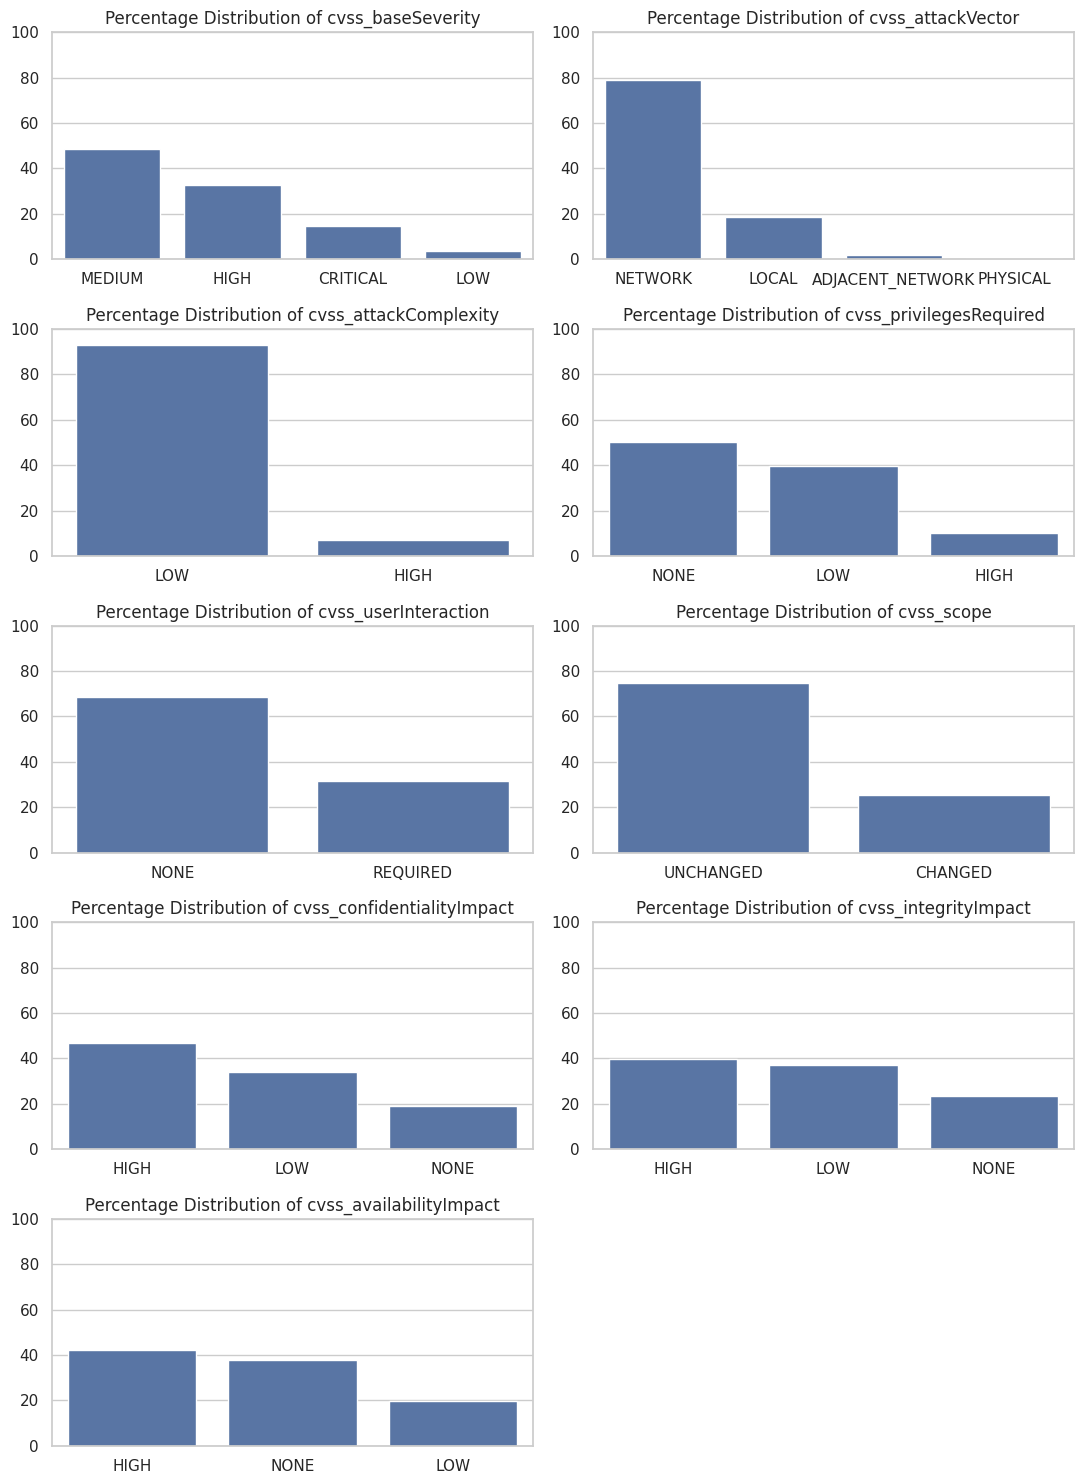

In [43]:
cols = [
    "cvss_baseSeverity", "cvss_attackVector", "cvss_attackComplexity",
    "cvss_privilegesRequired", "cvss_userInteraction", "cvss_scope",
    "cvss_confidentialityImpact", "cvss_integrityImpact", "cvss_availabilityImpact"
]

plt.figure(figsize=(11, 15))


for i, col in enumerate(cols, 1):
    plt.subplot(5, 2, i)

    # Compute percentages
    pct = (cvsss[col].value_counts(normalize=True) * 100).reset_index()
    pct.columns = [col, 'percentage']

    # Plot
    sns.barplot(data=pct, x=col, y='percentage', order=pct[col])
    plt.title(f"Percentage Distribution of {col}")
    plt.ylabel("")
    plt.ylim(0, 100)
    plt.xlabel("")

plt.tight_layout()
plt.show()

From these distributions we can see that of these vulnerabilities many require little to no privileges, can be executed through the network, have low attack complexity and require no user interaction.

## EPSS statistics

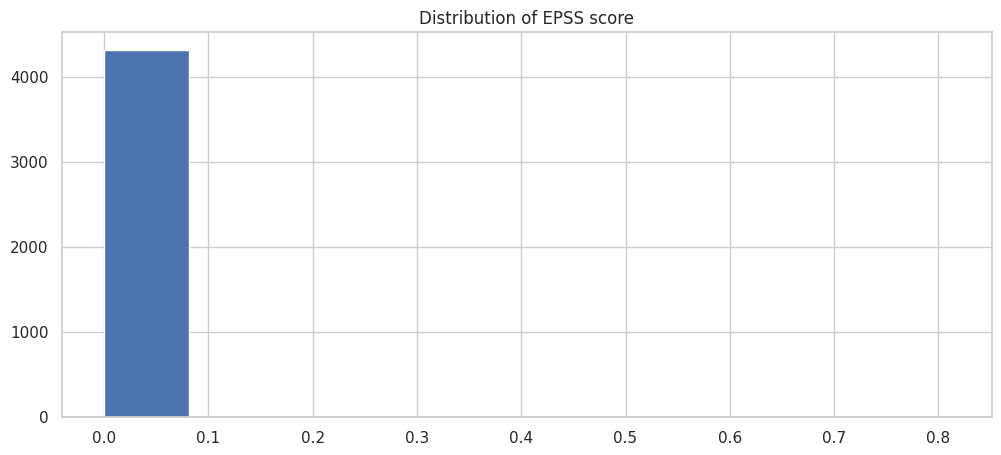

In [44]:
plt.figure(figsize=(12, 5))
plt.title("Distribution of EPSS score")
plt.hist(df["epss_x"])
plt.show()

As we can see, almost all of the vulnerabilities reported have an extremely low EPSS score.

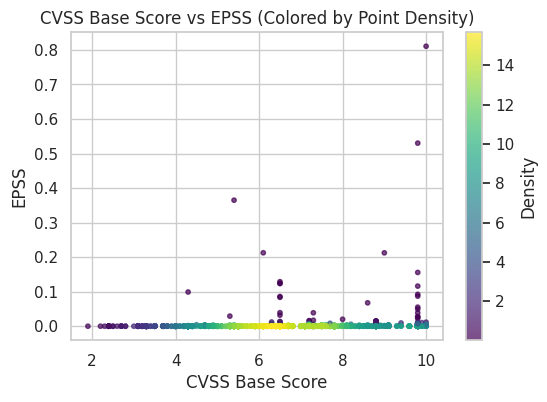

In [45]:
x = cvsss["cvss_baseScore"]
y = cvsss["epss_x"]

# Compute point densities
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

plt.figure(figsize=(6, 4))
plt.scatter(x, y, c=z, s=10, cmap='viridis', alpha=.7)
plt.title("CVSS Base Score vs EPSS (Colored by Point Density)")
plt.xlabel("CVSS Base Score")
plt.ylabel("EPSS")
plt.colorbar(label="Density")
plt.show()

Which is also highlighted by this graph: of all vulnerabilities observed during the time period, only a dozen have EPSS higher than 0.1,

In [46]:
print(
    f"Percentage of vulnerabilities in CISA KEV: {df["cve.cisaVulnerabilityName"].notna().sum() / len(df) * 100:.2f}%")

Percentage of vulnerabilities in CISA KEV: 0.21%


## Vulnerable vendors

In [47]:
print("Most vulnerable vendors: \n\n",
      df["vulnerable_cpes"].explode().value_counts().head(20))

Most vulnerable vendors: 

 vulnerable_cpes
cpe:2.3:o:google:android:14.0:*:*:*:*:*:*:*                     110
cpe:2.3:o:apple:macos:*:*:*:*:*:*:*:*                           109
cpe:2.3:o:google:android:15.0:*:*:*:*:*:*:*                     108
cpe:2.3:o:google:android:13.0:*:*:*:*:*:*:*                      99
cpe:2.3:o:microsoft:windows_server_2025:*:*:*:*:*:*:*:*          59
cpe:2.3:o:microsoft:windows_server_2022_23h2:*:*:*:*:*:*:*:*     57
cpe:2.3:o:microsoft:windows_server_2022:*:*:*:*:*:*:*:*          55
cpe:2.3:o:google:android:16.0:*:*:*:*:*:*:*                      54
cpe:2.3:o:microsoft:windows_server_2019:*:*:*:*:*:*:*:*          50
cpe:2.3:o:microsoft:windows_11_24h2:*:*:*:*:*:*:*:*              49
cpe:2.3:o:microsoft:windows_11_23h2:*:*:*:*:*:*:*:*              46
cpe:2.3:o:microsoft:windows_11_22h2:*:*:*:*:*:*:*:*              46
cpe:2.3:o:microsoft:windows_server_2016:*:*:*:*:*:*:*:*          44
cpe:2.3:o:microsoft:windows_10_1809:*:*:*:*:*:*:x64:*            40
cpe:

Most vulnerable vendors include common hardware vendors like Android and Apple, and for common browsers and softwares Google Chrome and pytorch (and others).

In [48]:
print("Most common CWE:\n\n", df["cwe_list"].explode().value_counts().head(20))

Most common CWE:

 cwe_list
CWE-79     711
CWE-89     428
CWE-74     294
CWE-862    203
CWE-352    160
CWE-94     134
CWE-284    119
CWE-77      96
CWE-78      89
CWE-434     86
CWE-918     74
CWE-22      73
CWE-20      67
CWE-125     67
CWE-200     66
CWE-787     62
CWE-266     62
CWE-119     61
CWE-502     61
CWE-285     57
Name: count, dtype: int64


The most common CWEs exploited are:
- CWE-79: Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting')
- CWE-89: Improper Neutralization of Special Elements used in an SQL Command ('SQL Injection')
- CWE-74: Improper Neutralization of Special Elements in Output Used by a Downstream Component ('Injection')
- CWE-862: Missing Authorization

In [49]:
top_25_cwe = ['CWE-79',
              'CWE-787',
              'CWE-89',
              'CWE-352',
              'CWE-22',
              'CWE-125',
              'CWE-78',
              'CWE-416',
              'CWE-862',
              'CWE-434',
              'CWE-94',
              'CWE-20',
              'CWE-77',
              'CWE-287',
              'CWE-269',
              'CWE-502',
              'CWE-200',
              'CWE-863',
              'CWE-918',
              'CWE-119',
              'CWE-476',
              'CWE-798',
              'CWE-190',
              'CWE-400',
              'CWE-306',
              ]

len(df[df['cwe_list'].apply(lambda lst: bool(set(lst) & set(top_25_cwe)))])

2423

From the previous we see that many of the vulnerabilities encountered are among the Top 2024 CWE.

# CVE selection


### <font color='blue'><b><i>TODO</i></b>
- Filter the CVEs with low EPSS (<1%)
- Select candidate CVEs
    - From the resulting subset, select 10 CVEs that you think will reach high EPSS by the end of the course.
    - Clearly describe the criteria you used for selection (e.g., high CVSS, popular software, CWE, popular vendor, number of references, keyword in description, manual inspection, random sampling, security blogs).
- Share the selected CVE ids with the instructor (by two weeks). Use the code cell below to produce the csv file to submit.
- Track the EPSS of your CVEs over time


In [50]:
df = df[df["epss_x"] < 0.01]

The first step was to filter the CVEs according to the rules, therefore excluding those with EPSS  1%.

In [51]:
df['percentile_diff'] = df['percentile_x'] - df['percentile_y']
df.sort_values("percentile_diff", axis=0, ascending=False, inplace=True)

The second step was to include a metric to sort CVEs with, some sort of predictor of how 'well' these CVEs will go wrt their EPSS scores.  
The difference in percentile could give information on how the EPSS of these vulnerabilities will evolve.  
Since it is based on earlier EPSS values it is kind of a dog chasing its tail. Nevertheless since EPSS can be seen more as a reaction system rather than a prediction system (because it is based on past data) estimating whether these vulnerabilities will be exploited with higher probability in the near future is tricky.  
EPSS cannot take into account PoCs that were reported on small sites, or new exploits for these CVEs that were just published since it takes some time (at least in the order of some days) to update, therefore better metrics could be considered.

In [52]:
df = df[(df["cvss_privilegesRequired"] == "NONE") &
        (df['cvss_userInteraction'] == 'NONE') &
        (df['cvss_attackVector'] == 'NETWORK') &
        (df['description'].str.contains('vulnerable', case=False)) &
        (df['cwe_list'].apply(lambda lst: bool(set(lst) & set(top_25_cwe))))]
len(df)

63

To further reduce the field of investigation, more features were considered:
* No privileges required to exploit the CVE: this kind of vulnerability (even though fairly common) broadens the horizon of the devices that can be subjects to these CVEs.
* No user interaction required: same reason
* Attack vector network: same
* Description contains vulnerable: in some cases there are helpful descriptions of vulnerabilities that don't come from the vendor itself (which may be working on a patch). This particular case could indicate that a problem was identified but was not solved (or at least in all instances)

In [53]:
df.iloc[0:10]['cve.id']

3730    CVE-2025-59834
930      CVE-2025-7045
401      CVE-2025-8268
3518    CVE-2025-10412
3515    CVE-2025-10147
3482     CVE-2025-9321
3531     CVE-2025-6921
3847    CVE-2025-10137
3596     CVE-2025-9054
4030     CVE-2025-9816
Name: cve.id, dtype: object

In [54]:
to_drop = ['cve_x',
           'cve_y',
           'epss_x',
           'percentile_x',
           'epss_y',
           'percentile_y',
           'percentile_diff']

df['cve'] = df['cve_x']
df['epss'] = df['epss_x']
df['percentile'] = df['percentile_x']
df.drop(columns=to_drop, inplace=True)

The 10 first CVEs were taken wrt the previous considerations and reported in the file.

In [57]:
nickname = 'qu_ale'


selected = ['CVE-2025-59834',
            'CVE-2025-7045',
            'CVE-2025-8268',
            'CVE-2025-10412',
            'CVE-2025-10147',
            'CVE-2025-9321',
            'CVE-2025-6921',
            'CVE-2025-10137',
            'CVE-2025-9054',
            'CVE-2025-9816']

df[df['cve.id'].isin(selected)].to_csv(
    os.path.join(data_path, f'{nickname}.csv'))